In [1]:
# Imports
import tensorflow as tf
import numpy as np
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

import math

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [2]:
## Import Custom Functions - Convert to .py

In [3]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str


In [4]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



In [5]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [6]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [7]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [8]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs



In [9]:
# load the Data
df = pd.read_csv("Data/spooky.csv")
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL


In [10]:
df.set_index("id")

,text,author
id,,
id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP
id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL
id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP
id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS
id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL
...,...,...
id17718,"I could have fancied, while I looked at it, that some eminent landscape painter had built it with his brush.",EAP
id08973,The lids clenched themselves together as if in a spasm.,EAP
id05267,"Mais il faut agir that is to say, a Frenchman never faints outright.",EAP


In [11]:
# length of each document - Using a lambda function

df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()


,id,text,author,sequence_length
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",EAP,41
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,14
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",EAP,36
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",MWS,34
4,id12958,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",HPL,27


In [12]:
df.describe()

,sequence_length
count,19579.000000
mean,26.730477
std,19.048353
min,2.000000
25%,15.000000
50%,23.000000
75%,34.000000
max,861.000000


The range of sequence lengths is 2-861 words and the average is about 27 words.

In [13]:
# se the RandomUnderSampler to balance the data based on the "author" column.
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(random_state=42)

df["author"].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [14]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df_ml,  _ = sampler.fit_resample(df, df['author'])
df_ml['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [15]:
# Change the author strings to integers using the following mapping: EAP: 0, HPL: 1, MWS: 2

In [16]:
# Create a map for targets
target_map = {'EAP':0,
              'HPL':1,
              'MWS':2}
# DEfine y and apply the target_map
y = df_ml['author'].map(target_map)
y.value_counts()

0    5635
1    5635
2    5635
Name: author, dtype: int64

In [17]:
y

11736    0
1342     0
16168    0
4112     0
14242    0
        ..
14963    2
18347    2
14513    2
16258    2
12533    2
Name: author, Length: 16905, dtype: int64

In [18]:
# Define X and y
X = df_ml['text']
y= df_ml['author'].map(target_map)


In [19]:
# Instantiate the LabelEncoder
#encoder = LabelEncoder()
# Fit and Transform the strings into integers
#y = pd.Series(encoder.fit_transform(y))
#y.value_counts()

In [20]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [21]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [22]:
# Determing how many samples for each split
# Calculate the number of samples for training 
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 11833 samples as training data
Use 3381 samples as validation data
The remaining 1691 samples will be used as test data.


In [23]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)


In [24]:
## Shuffling just the training data  
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [25]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')


 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


In [26]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

In [27]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 100
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
#sequence_vectorizer, vocab_lookup = fn.make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)

In [28]:
# Create the TextVectorization layer
count_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count"
)


In [29]:
# Fit the layer on the training texts
model = count_vectorizer.adapt(ds_texts)

In [30]:
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
count_vectorizer, count_lookup = make_text_vectorization_layer(train_ds, output_mode='count',
                                                                        verbose=True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'count',
    'output_sequence_length': None,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 20975}
)


In [31]:
# Check the size of the vocabulary
len(count_vectorizer.get_vocabulary())

20975

The size of the vocabulary is 20975

In [32]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()



20976

In [33]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['Text Vectorization is an essential tool for converting text into a format that machine learning models can use.'])
sequence



<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[ 6345,     1,    28,    35,  6996, 13401,    18,     1,  6345,
           57,     7,     1,    10,   833,  3862, 16160,   122,   521,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int64)>

In [34]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str



{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [35]:
# occasion is the 1000th term
int_to_str[1000]



'occasion'

# LSTM and GRU Models (Core)

# 1) LSTM

In [36]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )
# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)
# Set the batch size
BATCH_SIZE =32
import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")



    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [37]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)



In [38]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')



 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


In [39]:
# Define sequence length as a variable for future use
SEQUENCE_LENGTH = 100
# Define vectorizer layer. Use the custom function to build and fit the vectorizer before using it in model
sequence_vectorizer, vocab_lookup = make_text_vectorization_layer(train_ds, output_mode='int', output_sequence_length = SEQUENCE_LENGTH, verbose=True)




tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_3',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 100,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 20976}
)


In [40]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE



20976

In [41]:
# Define output dimension
EMBED_DIM = 150
EMBED_DIM



150

In [42]:
# Defining an embedding layer
embedding_layer = layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)



In [43]:
# Define classes variable
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [44]:
# Define a function for building an LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model



In [45]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



In [46]:
type(val_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

In [47]:
# Build the lstm model and specify the vectorizer
lstm_model = build_lstm_model(sequence_vectorizer)
# Define number of epocs
EPOCHS = 30
# Fit the model
history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

# Obtain the results
#results = fn.evaluate_classification_network(
 #   lstm_model, X_train=train_ds, 
  #  X_test=test_ds, history=history
#);



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 32s 82ms/step - loss: 1.1040 - accuracy: 0.3265 - val_loss

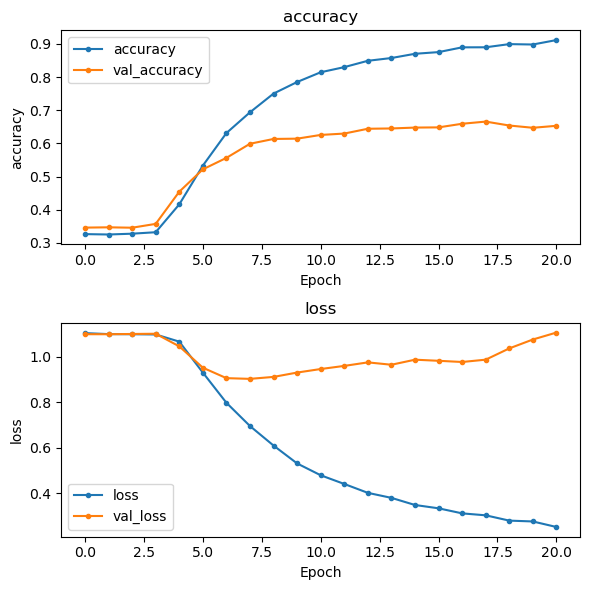


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      3906
           1       0.93      0.93      0.93      3952
           2       0.93      0.95      0.94      3975

    accuracy                           0.93     11833
   macro avg       0.93      0.93      0.93     11833
weighted avg       0.93      0.93      0.93     11833



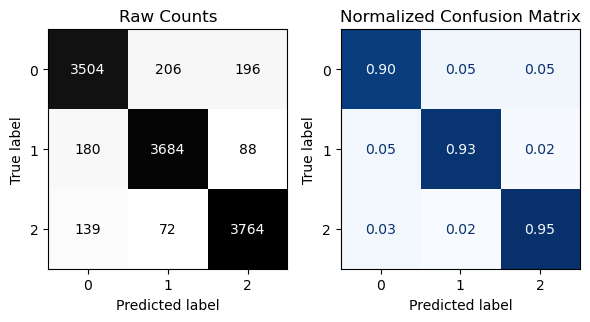


- Evaluating Training Data:
370/370 [==============================] - 6s 17ms/step - loss: 0.2155 - accuracy: 0.9255
{'loss': 0.21553632616996765, 'accuracy': 0.925547182559967}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.50      0.54       559
           1       0.60      0.69      0.64       560
           2       0.73      0.71      0.72       572

    accuracy                           0.64      1691
   macro avg       0.64      0.64      0.63      1691
weighted avg       0.64      0.64      0.64      1691



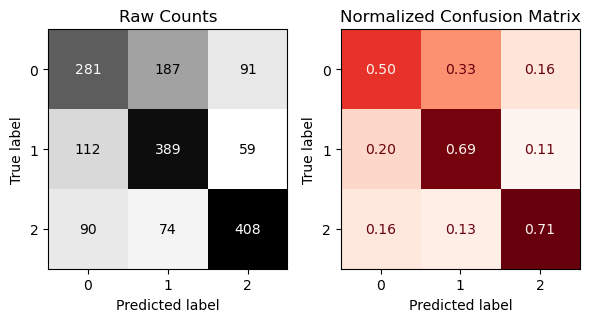


- Evaluating Test Data:
53/53 [==============================] - 1s 18ms/step - loss: 1.1444 - accuracy: 0.6375
{'loss': 1.1443613767623901, 'accuracy': 0.6374925971031189}


In [48]:
# Obtain the results
evaluate_classification_network(
    lstm_model, X_train=train_ds, 
    X_test=test_ds, history=history
)

# 2) GRU

In [49]:
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')



 VOCAB_SIZE: 20976
 EMBED_DIM: 150
 SEQUENCE_LENGTH: 100


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model


In [51]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]



In [52]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = fn.evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

NameError: name 'fn' is not defined

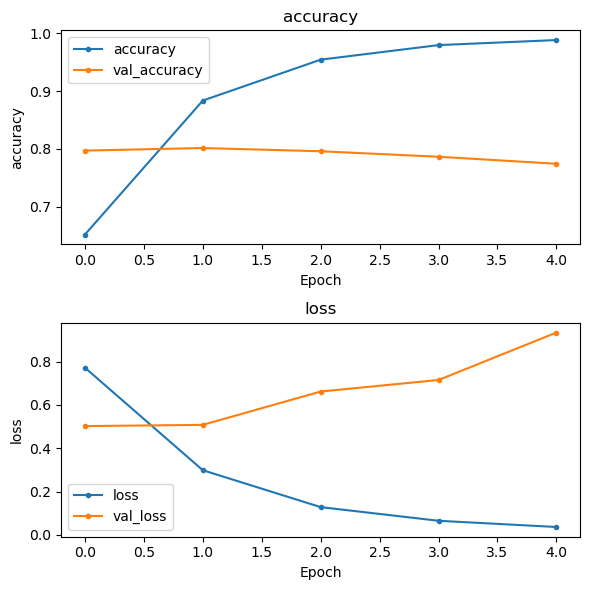


- Evaluating Network...


In [ ]:
# Obtain the results

evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);